In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
df = pd.read_csv("train.csv")

In [3]:
print(df.shape)
p = int(np.sqrt(df.shape[1]-1))
df.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


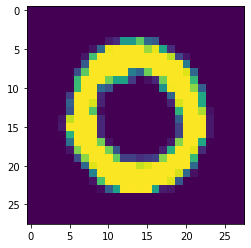

In [4]:
plt.imshow(df.iloc[1,1:].as_matrix().reshape(p,-1))

In [5]:
chosen = np.random.choice(range(len(df)),int(.9*len(df)),replace = False)
train_df = df.iloc[chosen,:]
valid_df = df.drop(axis = 0, index = chosen)
print(len(valid_df))
print(len(df))

4200
42000


In [86]:
class MnistDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, df, transform=None, width = p):
        self.data_frame = df
        self.transform = transform
        self.width = width

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        pixels = transforms.ToTensor()(self.data_frame.iloc[idx,1:].values.reshape(self.width,-1,1)).to(dtype = torch.float)
        label = self.data_frame.iloc[idx,0]
        if self.transform:
            pixels = self.transform(pixels)
        return [label,pixels]

In [124]:
trans = transforms.Compose([
#    transforms.ToPILImage(),
#    transforms.CenterCrop(28),
#    transforms.ToTensor()
])
train_dataset = MnistDataset(df = train_df,transform = trans)
valid_set = MnistDataset(df = valid_df,transform = trans)
all_set = MnistDataset(df = df,transform = trans)

In [126]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=100,
                                          shuffle=False, num_workers=6)
validloader = torch.utils.data.DataLoader(valid_set, batch_size=1,
                                          shuffle=False, num_workers=6)
allloader = torch.utils.data.DataLoader(all_set, batch_size=100,
                                          shuffle=False, num_workers=6)

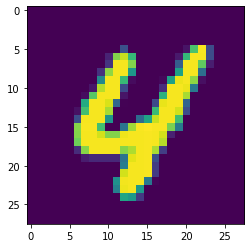

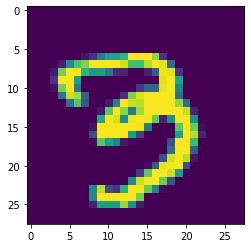

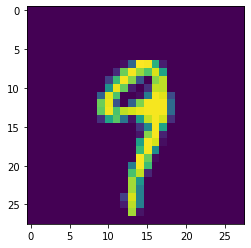

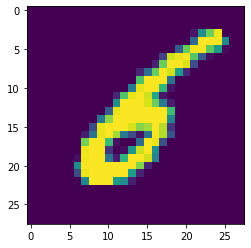

In [127]:
for i,data in enumerate(trainloader,0):
    if i >= 1:
        break
    label, pixels = data
    for j in range(4):
        plt.imshow(pixels.numpy()[j][0])
        plt.show()

In [160]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [166]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=.003, momentum=.9)
optimizer = optim.Adam(net.parameters(), lr=.0003, betas=(0.9, 0.999))

In [167]:
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        labels, inputs = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs.to(dtype = torch.float))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            valid_cor = 0.0
            total = 0
            for data in validloader:
                labels, inputs = data
                total += len(labels)
                valid_outputs = net(inputs.to(dtype = torch.float))
                valid_predict = torch.max(valid_outputs.data,1)[1]
                valid_cor += (valid_predict == labels).item()
            print('valid accuracy: %.4f'%(100*float(valid_cor)/total))

print('Finished Training')

[1,   100] loss: 0.004
valid accuracy: 98.9286
[1,   200] loss: 0.003
valid accuracy: 98.8333
[1,   300] loss: 0.001
valid accuracy: 98.9524
[2,   100] loss: 0.000
valid accuracy: 98.9524
[2,   200] loss: 0.000
valid accuracy: 98.9286
[2,   300] loss: 0.000
valid accuracy: 99.0000
[3,   100] loss: 0.000
valid accuracy: 99.0476
[3,   200] loss: 0.000
valid accuracy: 99.0238
[3,   300] loss: 0.000
valid accuracy: 98.9762
[4,   100] loss: 0.000
valid accuracy: 99.0238
[4,   200] loss: 0.000
valid accuracy: 99.0476
[4,   300] loss: 0.000
valid accuracy: 99.0476
[5,   100] loss: 0.000
valid accuracy: 99.0476
[5,   200] loss: 0.000
valid accuracy: 99.0476
[5,   300] loss: 0.000
valid accuracy: 99.0476
Finished Training


In [168]:
predict_array = []
for data in validloader:
    labels, inputs = data
    total += len(labels)
    valid_outputs = net(inputs.to(dtype = torch.float))
    valid_predict = torch.max(valid_outputs.data,1)[1]
    predict_array.append(valid_predict.numpy()[0])
predict_array = np.array(predict_array)
confusion_mtx = confusion_matrix(valid_df["label"], predict_array)

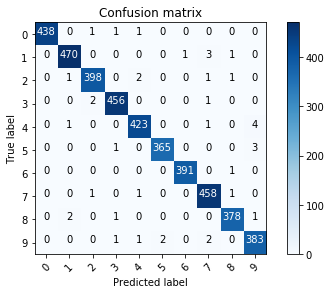

In [169]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

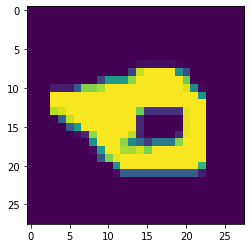

2


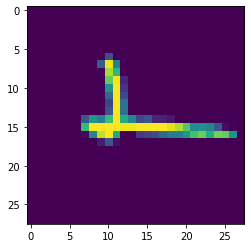

4


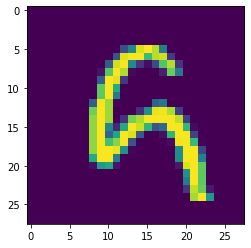

5


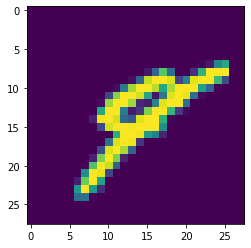

9


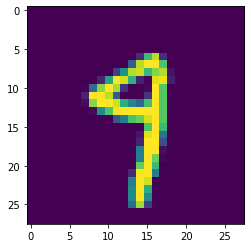

9


In [170]:
num = 0
for i in range(len(predict_array)):
    if valid_df.iloc[i,0] != predict_array[i]:
        plt.imshow(valid_df.iloc[i,1:].values.reshape([28,28]))
        plt.show()
        print(predict_array[i])
        num += 1
    if num >= 5:
        break

In [175]:
net_all = Net()
criterion = nn.CrossEntropyLoss()

In [178]:
#optimizer = optim.SGD(net_all.parameters(), lr=.003, momentum=.9)
optimizer = optim.Adam(net_all.parameters(), lr=.0003, betas=(0.9, 0.999))

In [179]:
for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(allloader, 0):
        # get the inputs
        labels, inputs = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net_all(inputs.to(dtype = torch.float))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 0.003
[1,   200] loss: 0.003
[1,   300] loss: 0.001
[1,   400] loss: 0.001
[2,   100] loss: 0.000
[2,   200] loss: 0.000
[2,   300] loss: 0.000
[2,   400] loss: 0.000
[3,   100] loss: 0.000
[3,   200] loss: 0.000
[3,   300] loss: 0.000
[3,   400] loss: 0.000
[4,   100] loss: 0.000
[4,   200] loss: 0.000
[4,   300] loss: 0.000
[4,   400] loss: 0.000
[5,   100] loss: 0.000
[5,   200] loss: 0.000
[5,   300] loss: 0.000
[5,   400] loss: 0.000
Finished Training


In [180]:
test_df = pd.read_csv("test.csv")
test_np = test_df.values.reshape([-1,1,28,28]).astype(float)
test_data = torch.from_numpy(test_np)

In [181]:
pred_test = torch.argmax(net_all(test_data.to(dtype = torch.float)),1)

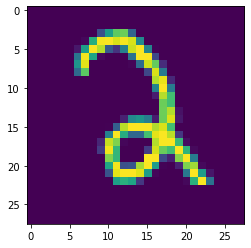

tensor(2)


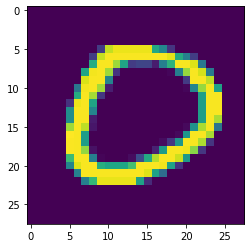

tensor(0)


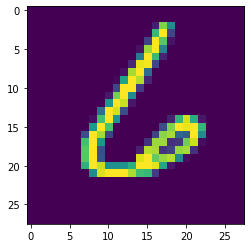

tensor(6)


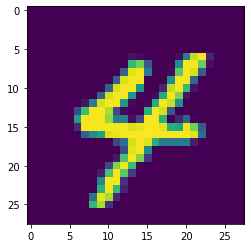

tensor(4)


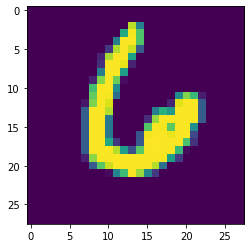

tensor(6)


In [182]:
for i in range(1105,1110):
    plt.imshow(test_np[i][0])
    plt.show()
    print(pred_test[i])

In [184]:
def export_csv(model_name, predictions):
    df = pd.DataFrame(predictions.tolist(), columns=['Label'])
    df['ImageId'] = df.index + 1
    file_name = f'submission_{model_name}.csv'
    print('Saving ',file_name)
    df[['ImageId','Label']].to_csv(file_name, index = False)
export_csv("cnn3",pred_test)
torch.save(net_all.state_dict(), 'model3.ckpt')

Saving  submission_cnn3.csv
